In [1047]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd
import torch.optim as optim
import cv2

In [1075]:
config = {
    'data_dir': './datasets/train_zip/train',
    'data_test_dir': './datasets/test_zip/test',
    'class_mapping': {'apple': 0, 'banana': 1, 'orange': 2},
    'class_mapping_num': {0: 'apple', 1: 'banana', 2: 'orange'}  
}

In [1076]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}
data_test = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

In [1050]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None
    with Image.open(file_path) as img:
        width, height = img.size
    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    if size is not None:
        width = size.find('width').text
        height = size.find('height').text
        if width and height:
            return int(width), int(height)
    return 0, 0  


def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height


def parse_xml(xml_file, image_file_path, dataframe):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    
    width, height = get_image_dimensions(xml_file, image_file_path)

    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        dataframe['filename'].append(filename)
        dataframe['width'].append(width)
        dataframe['height'].append(height)
        dataframe['class'].append(obj_class)
        dataframe['xmin'].append(xmin)
        dataframe['ymin'].append(ymin)
        dataframe['xmax'].append(xmax)
        dataframe['ymax'].append(ymax)

In [1051]:
def fill_dataframe(dataframe, data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    for image_file in images:
        xml_file = image_file.replace('.jpg', '.xml')
        xml_path = os.path.join(data_dir, xml_file)
        image_path = os.path.join(data_dir, image_file)
        if os.path.exists(xml_path):
            parse_xml(xml_path, image_path, dataframe)

fill_dataframe(data, config['data_dir'])
fill_dataframe(data_test, config['data_test_dir'])

In [1052]:
train_df = pd.DataFrame(data)
test_df = pd.DataFrame(data_test)

In [1053]:
def transform_data(df):
    transformed_data = []

    for filename, group in df.groupby('filename'):
        data = {
            'filename': filename,
            'width': group['width'].iloc[0],
            'height': group['height'].iloc[0],
            'objects': []
        }

        for _, row in group.iterrows():
            data['objects'].append({
                'class': row['class'],
                'xmin': row['xmin'],
                'ymin': row['ymin'],
                'xmax': row['xmax'],
                'ymax': row['ymax']
            })
        
        transformed_data.append(data)

    return transformed_data

In [1054]:
train_df = transform_data(train_df)
test_df = transform_data(test_df)

In [1055]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1056]:
class FruitDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, image_size=(224, 224), num_anchors=9):
        self.data_dir = data_dir
        self.transforms = transforms
        self.image_size = image_size
        self.dataframe = df
        self.num_anchors = num_anchors  # Number of anchors

    def __len__(self):
        return len(self.dataframe)
    
    def class_to_label(self, class_name):
        class_mapping = config['class_mapping']
        return class_mapping.get(class_name, 0) 
    
    def pad_bboxes_and_labels(self, bboxes, labels):
        num_boxes = bboxes.size(0)
        if num_boxes > self.num_anchors:
            bboxes = bboxes[:self.num_anchors]
            labels = labels[:self.num_anchors]
        else:
            padding_bboxes = torch.zeros((self.num_anchors - num_boxes, 4), dtype=bboxes.dtype)
            padding_labels = torch.zeros((self.num_anchors - num_boxes,), dtype=labels.dtype)
            bboxes = torch.cat([bboxes, padding_bboxes], dim=0)
            labels = torch.cat([labels, padding_labels], dim=0)
        return bboxes, labels

    def __getitem__(self, idx):
        obj = self.dataframe[idx]
        file_name = obj['filename']
        image_path = os.path.join(self.data_dir, file_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = image.resize(self.image_size)
        
        bboxes = []
        labels = []
        objects = obj['objects']
        for obj in objects:
            class_name = obj['class']
            label = self.class_to_label(class_name)
            labels.append(label)
            
            bbox = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']]
            bboxes.append(bbox)
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        # Apply padding to match num_anchors
        bboxes, labels = self.pad_bboxes_and_labels(bboxes, labels)
        
        if self.transforms:
            image = self.transforms(image)
        else: 
            image = transforms.ToTensor()(image)
            
        # print("image", image.size())
        # print("bboxes", bboxes.size())
        # print("labels", labels.size())
        
        return image, bboxes, labels

In [1057]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [1058]:
def pad_bboxes_and_labels(bboxes, labels, num_anchors):
    batch_size, num_boxes, _ = bboxes.size()  # Get batch size and number of boxes per image

    # Check if we need to pad
    if num_boxes > num_anchors:
        bboxes = bboxes[:, :num_anchors, :]  # Select the first num_anchors bounding boxes
        labels = labels[:, :num_anchors]  # Select the first num_anchors labels
    else:
        padding_bboxes = torch.zeros((batch_size, num_anchors - num_boxes, 4), dtype=bboxes.dtype, device=bboxes.device)
        padding_labels = torch.zeros((batch_size, num_anchors - num_boxes), dtype=labels.dtype, device=labels.device)
        
        bboxes = torch.cat([bboxes, padding_bboxes], dim=1)  # Concatenate along the num_boxes dimension (dim=1)
        labels = torch.cat([labels, padding_labels], dim=1)  # Concatenate along the num_boxes dimension (dim=1)

    return bboxes, labels

In [1059]:
class AlexNetObjectDetector(nn.Module):
    def __init__(self, num_classes, num_anchors=9):
        super(AlexNetObjectDetector, self).__init__()
        self.num_classes = num_classes
        self.feature_extractor = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).features

        self.bbox_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_anchors * 4)  # Outputting bounding boxes for multiple anchors (x, y, width, height)
        )

        self.class_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_anchors * num_classes)  # Outputting class scores for each anchor
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        
        bbox_preds = self.bbox_head(features).view(-1, 9, 4)  # Reshape to (batch_size, num_anchors, 4)
        class_scores = self.class_head(features).view(-1, 9, self.num_classes)  # Reshape to (batch_size, num_anchors, num_classes)
        
        return bbox_preds, class_scores


In [1067]:
def train_model(num_epochs, batch_size, learning_rate, log_epochs=True):
    num_classes = len(config['class_mapping'])
    train_dataset = FruitDataset(data_dir=config['data_dir'], df=train_df, transforms=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = AlexNetObjectDetector(num_classes)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    bbox_criterion = nn.SmoothL1Loss()
    class_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    bbox_loss_history = []
    class_loss_history = []
    accuracy_history = []
    min_total_loss = float('inf')  # Initialize with a high value to find the minimum
    
    for epoch in range(num_epochs):
        model.train()
        running_bbox_loss = 0.0
        running_class_loss = 0.0
        correct_preds = 0
        total_preds = 0
    
        for images, bboxes, labels in train_loader:
            images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)
            
            bbox_preds, class_preds = model(images)
            
            bboxes, labels = pad_bboxes_and_labels(bboxes, labels, 9)
            class_preds = class_preds.view(-1, num_classes)  
            labels = labels.view(-1) 
    
            bbox_loss = bbox_criterion(bbox_preds, bboxes)
            class_loss = class_criterion(class_preds, labels)
            total_loss = bbox_loss + class_loss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
    
            running_bbox_loss += bbox_loss.item()
            running_class_loss += class_loss.item()
    
            _, predicted = torch.max(class_preds, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        avg_bbox_loss = running_bbox_loss / len(train_loader)
        avg_class_loss = running_class_loss / len(train_loader)
        epoch_accuracy = 100 * correct_preds / total_preds
        
        bbox_loss_history.append(avg_bbox_loss)
        class_loss_history.append(avg_class_loss)
        accuracy_history.append(epoch_accuracy)
        
        if total_loss.item() < min_total_loss:
            min_total_loss = total_loss.item()

        if(log_epochs): 
            print(f"Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, Class Loss: {avg_class_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Min Total Loss: {min_total_loss:.4f}")
    
    print("Training complete!")
    return min_total_loss


In [1069]:
def objective(trial):
    num_epochs = trial.suggest_int("num_epochs", 5, 30)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    
    accuracy = train_model(num_epochs, batch_size, learning_rate, False)
    
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-11-13 12:58:46,136] A new study created in memory with name: no-name-988a8abe-9832-4287-a1fb-3c2379897c62
/var/folders/9p/4ntgw9k12250qf7z_px_hrnh0000gn/T/ipykernel_9814/2120542180.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iC

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Training complete!
Best hyperparameters: {'num_epochs': 7, 'batch_size': 8, 'learning_rate': 0.003963057751625324}
Best accuracy: 13.184961318969727


In [1079]:
train_model(15, 8, 1e-4)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/15], BBox Loss: 69.0047, Class Loss: 0.4486, Accuracy: 86.53%, Min Total Loss: 44.0948


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/15], BBox Loss: 62.9006, Class Loss: 0.1793, Accuracy: 93.24%, Min Total Loss: 44.0948


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/15], BBox Loss: 59.2579, Class Loss: 0.1176, Accuracy: 95.56%, Min Total Loss: 37.2320


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/15], BBox Loss: 57.7332, Class Loss: 0.0819, Accuracy: 96.81%, Min Total Loss: 37.2320


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/15], BBox Loss: 56.1976, Class Loss: 0.0476, Accuracy: 98.10%, Min Total Loss: 37.2320


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/15], BBox Loss: 55.3935, Class Loss: 0.0454, Accuracy: 98.56%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/15], BBox Loss: 54.0801, Class Loss: 0.0465, Accuracy: 98.19%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/15], BBox Loss: 51.5901, Class Loss: 0.0284, Accuracy: 99.07%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/15], BBox Loss: 47.2529, Class Loss: 0.0581, Accuracy: 98.24%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/15], BBox Loss: 49.1227, Class Loss: 0.0870, Accuracy: 97.31%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/15], BBox Loss: 46.4462, Class Loss: 0.0445, Accuracy: 98.47%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/15], BBox Loss: 40.4632, Class Loss: 0.0271, Accuracy: 99.21%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/15], BBox Loss: 38.1468, Class Loss: 0.0106, Accuracy: 99.86%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/15], BBox Loss: 37.0929, Class Loss: 0.0097, Accuracy: 99.81%, Min Total Loss: 15.8968


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/15], BBox Loss: 36.9703, Class Loss: 0.0048, Accuracy: 99.95%, Min Total Loss: 15.8968
Training complete!


15.896757125854492

In [1082]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def unnormalize_image(image, mean, std):
    unnormalize = T.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1.0 / s for s in std])
    return unnormalize(image)

def plot_image(image_path, bboxes, labels):
    image = Image.open(config['data_test_dir'] + "/" + image_path).convert('RGB')
    
    # Convert image to tensor
    transform = T.ToTensor()
    image_tensor = transform(image)
    
    unnormalized_image = unnormalize_image(image_tensor, mean, std)
    image_np = unnormalized_image.cpu().permute(1, 2, 0).numpy()
    
    fig, ax = plt.subplots(1, figsize=(6, 12))
    ax.imshow(image_np)

    for bbox, label in zip(bboxes, labels):
        label_text = config['class_mapping_num'][label.item()]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(bbox[0], bbox[1] - 10, label_text, color='red', fontsize=12, ha='center')

    plt.show()

libpng warning: iCCP: known incorrect sRGB profile


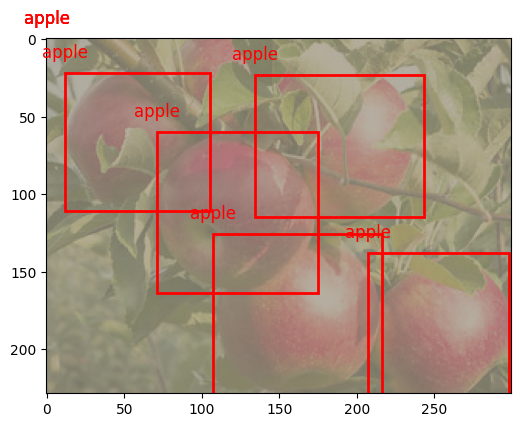

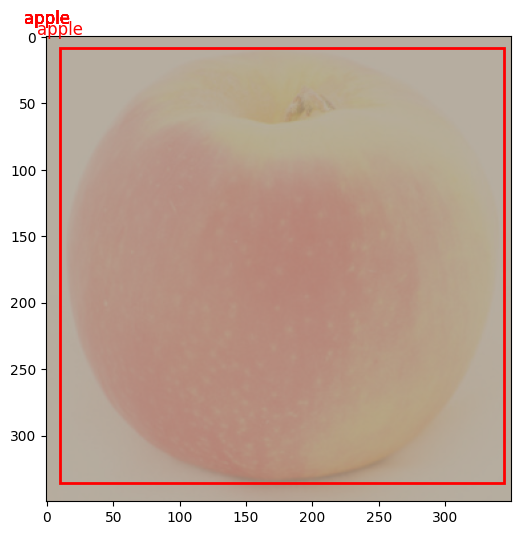

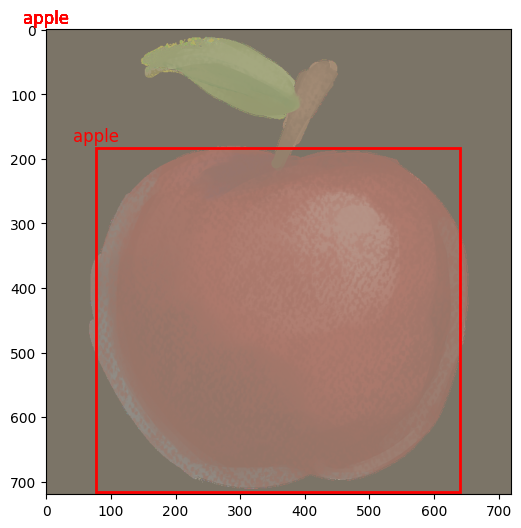

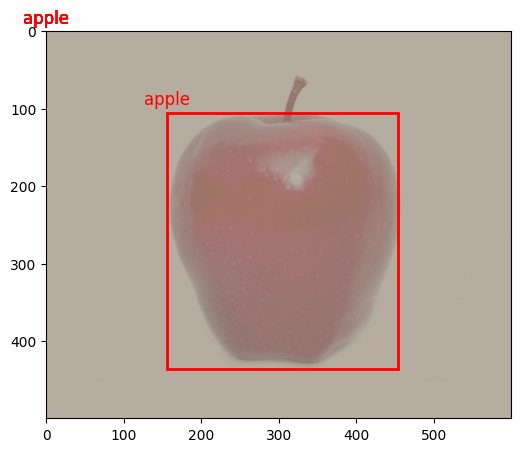

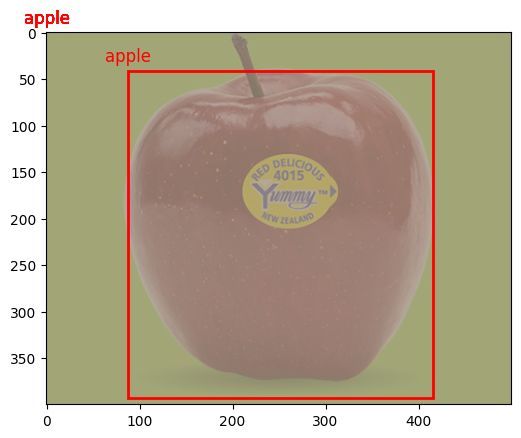

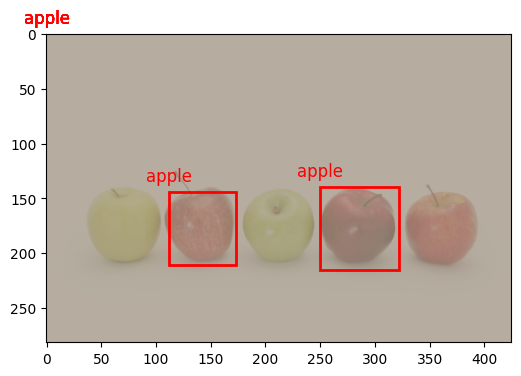

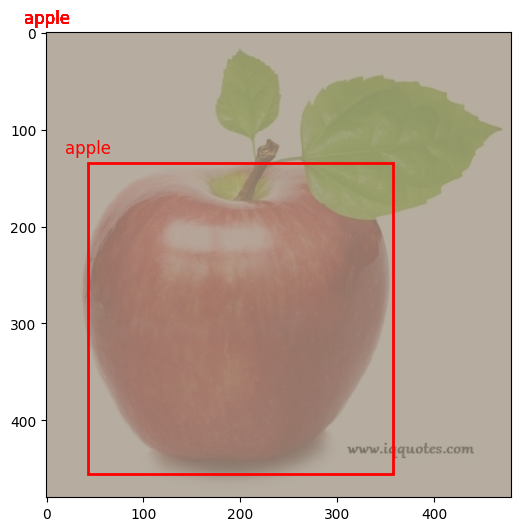

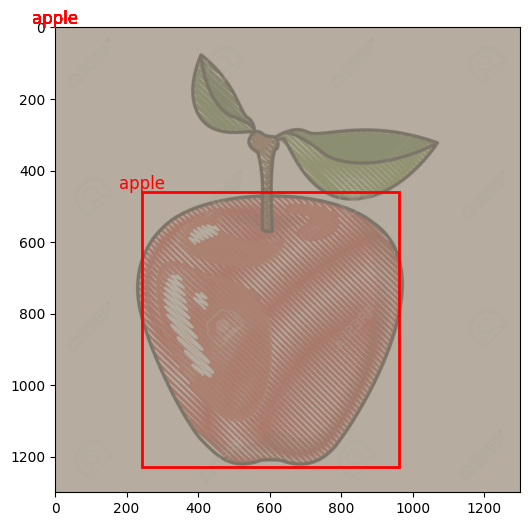

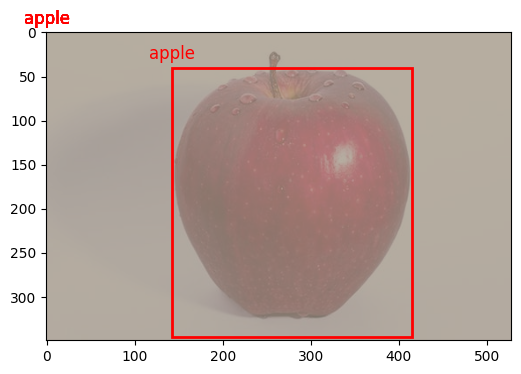

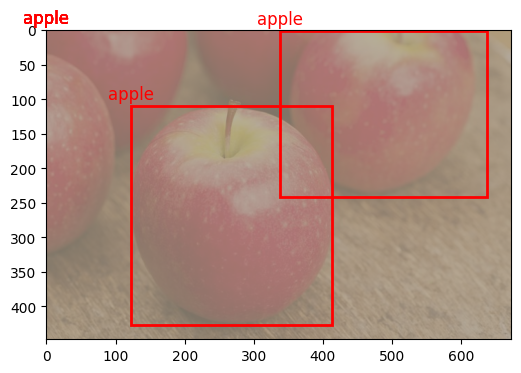

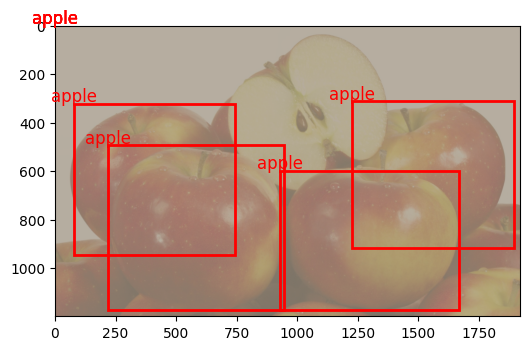

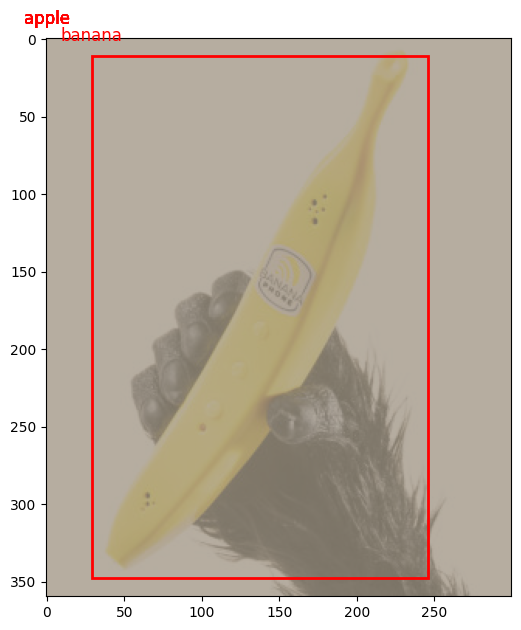

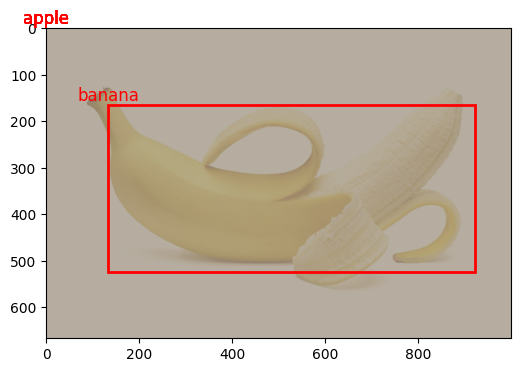

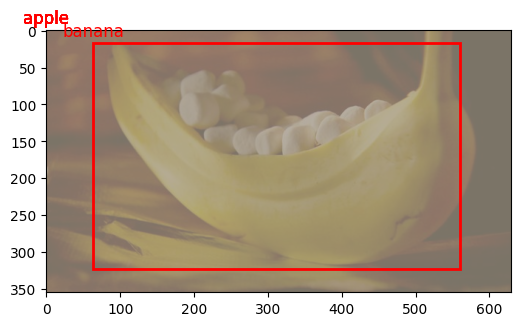

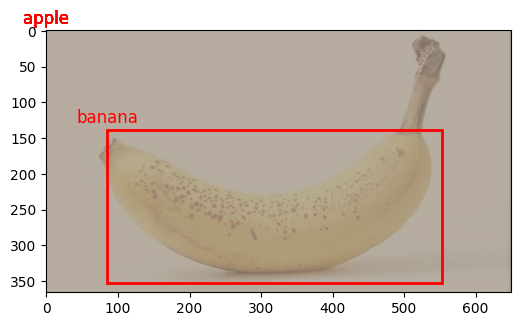

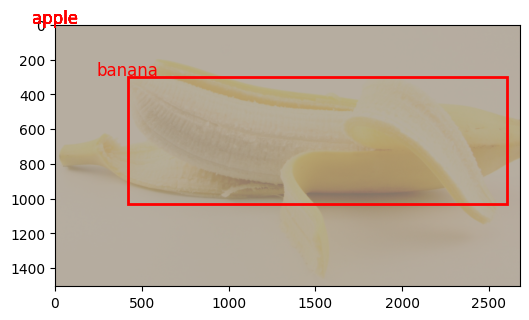

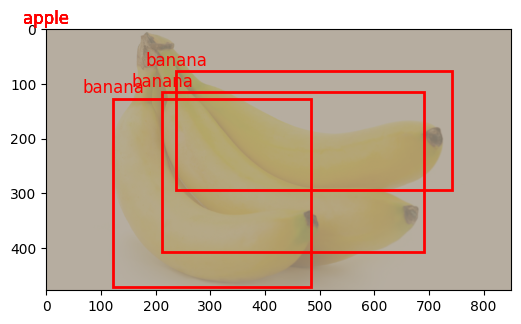

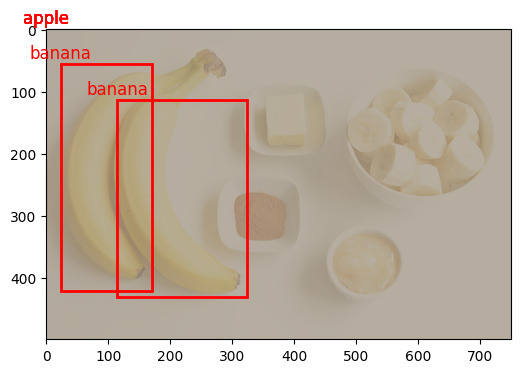

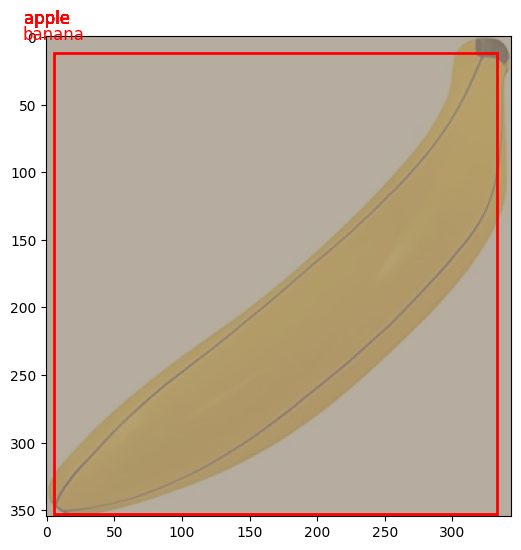

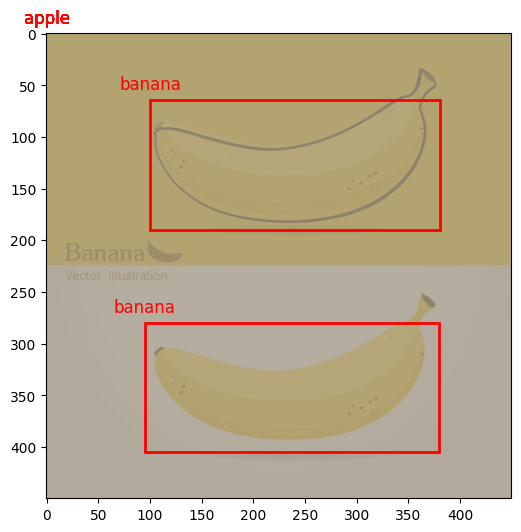

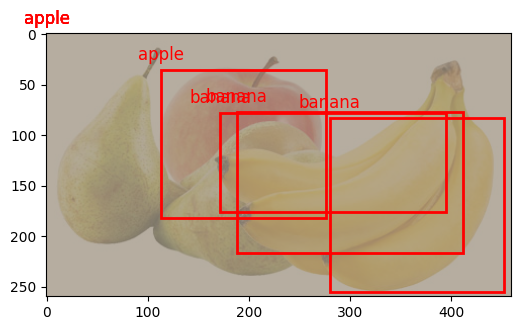

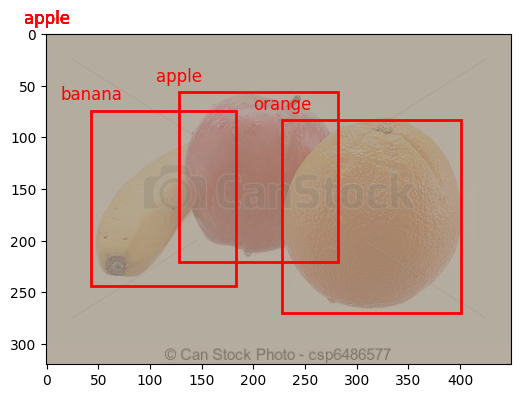

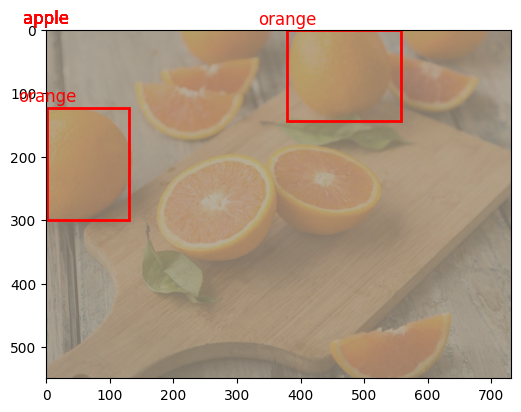

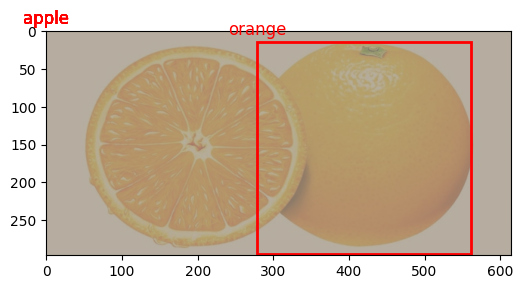

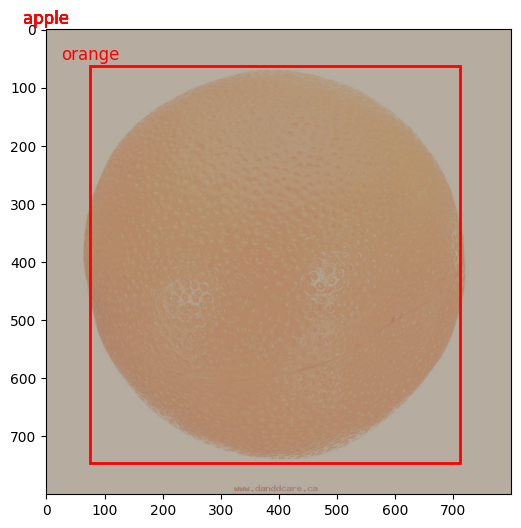

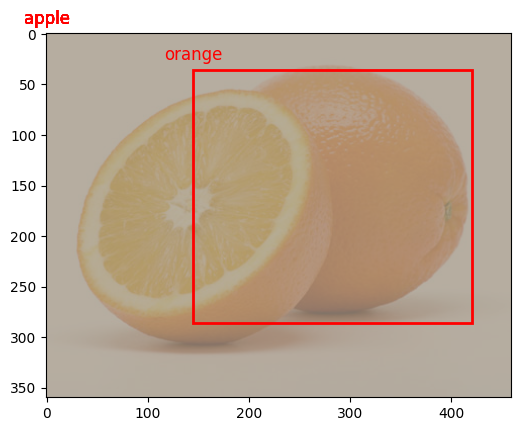

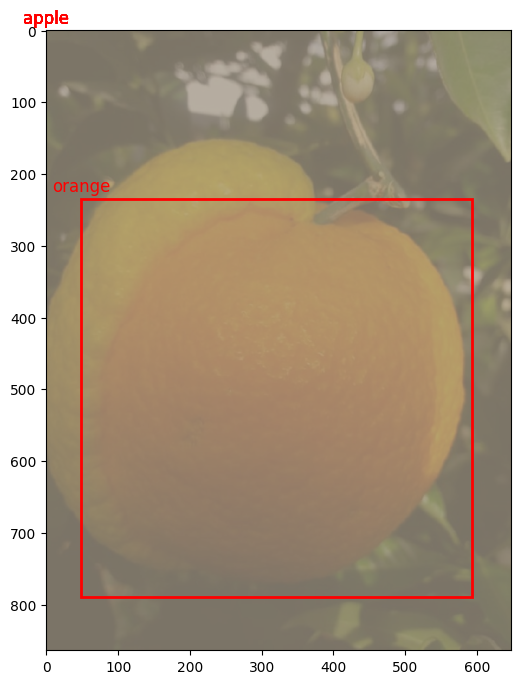

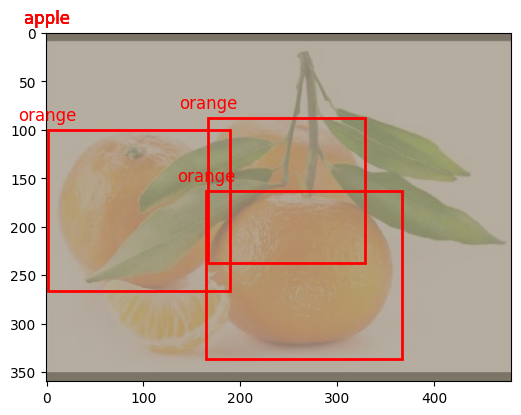

IndexError: list index out of range

In [1083]:
test_dataset = FruitDataset(data_dir=config['data_test_dir'], df=test_df, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_bbox_loss = 0.0
test_class_loss = 0.0
correct_test_preds = 0
total_test_preds = 0

with torch.no_grad():
    for idx, (images, bboxes, labels) in enumerate(test_loader):
        images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)
        image_paths = [test_df[i]['filename'] for i in range(idx * batch_size, (idx + 1) * batch_size)]
        plot_image(image_paths[0], bboxes[0], labels[0])
        plot_image(image_paths[1], bboxes[1], labels[1])
        plot_image(image_paths[2], bboxes[2], labels[2])
        plot_image(image_paths[3], bboxes[3], labels[3])
        
        bbox_preds, class_preds = model(images)
        
        bboxes, labels = pad_bboxes_and_labels(bboxes, labels, 9)
        class_preds = class_preds.view(-1, num_classes)
        labels = labels.view(-1)

        bbox_loss = bbox_criterion(bbox_preds, bboxes)
        class_loss = class_criterion(class_preds, labels)
        
        test_bbox_loss += bbox_loss.item()
        test_class_loss += class_loss.item()

        _, predicted = torch.max(class_preds, 1)
        correct_test_preds += (predicted == labels).sum().item()
        total_test_preds += labels.size(0)

avg_test_bbox_loss = test_bbox_loss / len(test_loader)
avg_test_class_loss = test_class_loss / len(test_loader)
test_accuracy = 100 * correct_test_preds / total_test_preds

print(f"Test BBox Loss: {avg_test_bbox_loss:.4f}, Test Class Loss: {avg_test_class_loss:.4f}, "
      f"Test Accuracy: {test_accuracy:.2f}%")

<h3>Висновки:</h3>
<ul>
    <li>Модель з точністю 100% класифікує зображення на тестовому датасеті, але 5% предметів не побачила</li>
    <li>Гарно обирає bounding box для всіх обʼєктів, але завеликої точності немає</li>    
    <li>Обрано список гіперпараметрів: num_epochs, batch_size, learning_rate</li    
    <li>Після тюнингу гіперпараметрів вдалося несильно підвищити loss function for bounding box</li>>
    <li>
        Було обрано 2 функції втрат: 
        <ul>
            <li>для image classification - CrossEntropyLoss, бо він дає великі покарання за неправильно вгаданий клас і є класичним варіантом для цієї задачі.</ol>
            <li>Для обирання bounding box - Smooth L1 Loss, це гарний баланс між L1 loss та L2 loss, бо не ігнорує малих помилок (як L1 loss) та не дає завеликі покарання для великих помилок (як L2 loss). Використовується в інших моделях для object detection, таких як Faster R-CNN</ol>
        </ul>
    </li>
</ul>